# Generative Model (Coffees dataset)

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


In [7]:
# import local utility functions
import sys
sys.path.append('../utils')
import utils as utl

## Load raw data and plot

In [8]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/coffees/FTIR_instant_coffees.csv')
data.head(5)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
1,10.364243,10.569554,10.448875,10.100696,9.620371,8.882499,8.415529,8.210217,7.916430,7.806151,...,1.493133,1.475563,1.464682,1.456444,1.442087,1.433698,1.425288,1.418705,1,Arabica
2,13.118324,13.507084,13.473495,12.871428,12.181919,11.239480,10.515672,10.468178,10.428742,10.212771,...,2.236715,2.214229,2.196218,2.181646,2.164602,2.146423,2.133255,2.121559,1,Arabica
3,15.668409,15.803868,15.977607,15.569489,14.950423,14.029599,13.396739,13.092360,12.784991,12.829988,...,3.020125,2.987411,2.963816,2.954810,2.942520,2.909018,2.880989,2.876201,1,Arabica
4,16.634960,17.055263,17.610495,17.211594,16.217897,15.287751,14.424133,13.928921,13.551499,13.288979,...,3.310964,3.281866,3.263161,3.241584,3.213549,3.183820,3.157357,3.146584,1,Arabica


In [9]:
# shuffle data rows
data = data.sample(frac=1, random_state=42)

Arabica: blue
Robusta: red


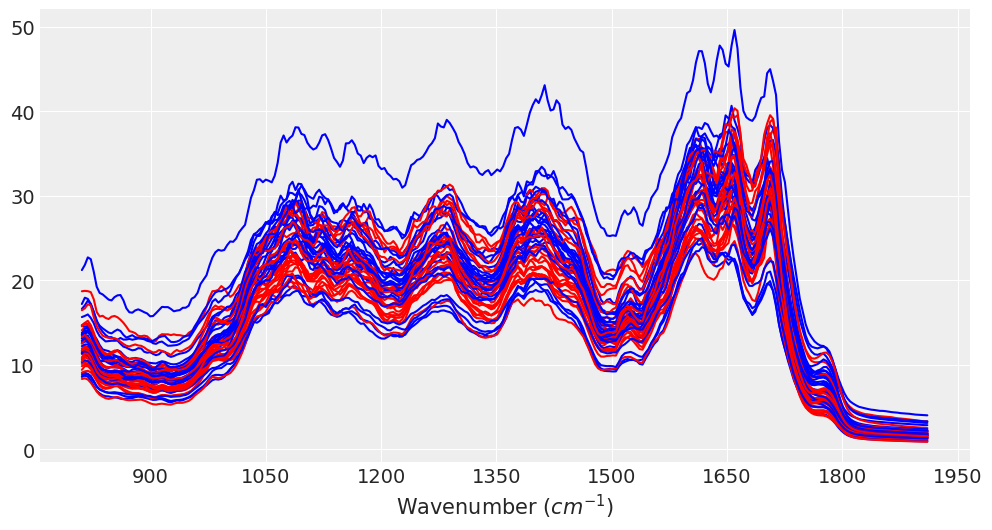

In [13]:
# name of column containing the labels
label_col = 'label'

# number of non-data columns at right of dataframe
ndata_cols = -2

# list of class labels
clabels = list({lbl for lbl in data.iloc[:,data.columns.to_list().index(label_col)].tolist()})
clabels.sort()

# plot dataframe
utl.plot_data(data, ndata_cols, label_col, 50)

In [6]:
#data.describe()

In [7]:
# number of samples from each class
data[label_col].value_counts()

Arabica    29
Robusta    27
Name: label, dtype: int64

In [8]:
# store data values for class A and B
df_a = data.query("label ==  @clabels[0]")
df_b = data.query("label ==  @clabels[1]")

x_n = data.columns[:ndata_cols]

x_sa = df_a[x_n].values
x_sb = df_b[x_n].values

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a,b} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [9]:
with pm.Model() as model_gm:
    
    mu_m = pm.Lognormal('mu_m', mu=0, sigma=1) 
    sigma_ab = pm.Gamma('sigma_ab', alpha=1., beta=1.)
    sigma_mu = pm.HalfNormal('sigma_mu', sigma_ab)
    mu = pm.Normal('mu', mu=mu_m, sd=sigma_mu, shape=(len(clabels),len(x_n)))
    
    sigma_s = pm.Gamma('sigma_s', alpha=1., beta=1.)
    sigma = pm.HalfNormal('sigma', sigma_s)
    
    class_a = pm.Normal('class_a', mu=mu[0], sd=sigma, observed=x_sa)
    class_b = pm.Normal('class_b', mu=mu[1], sd=sigma, observed=x_sb)

    trace_gm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:53<00:00, 93.96draws/s] 


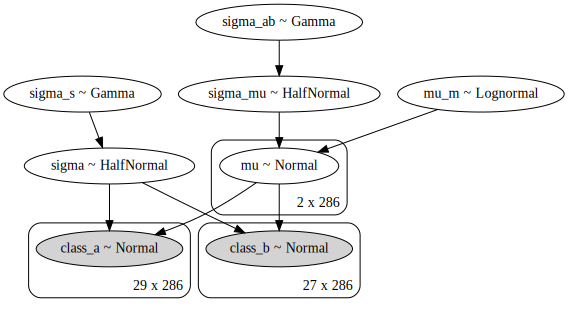

In [10]:
pm.model_to_graphviz(model_gm)

In [11]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",13.065,0.595,11.950,14.155,0.006,0.004,10989.0,10936.0,10929.0,2987.0,1.0
"mu[0,1]",13.344,0.606,12.181,14.434,0.007,0.005,8580.0,8483.0,8623.0,2840.0,1.0
"mu[0,2]",13.399,0.619,12.259,14.542,0.007,0.005,8026.0,7975.0,7969.0,2527.0,1.0
"mu[0,3]",12.948,0.600,11.766,14.008,0.006,0.004,9495.0,9495.0,9519.0,2762.0,1.0
"mu[0,4]",12.200,0.620,11.074,13.426,0.007,0.005,8698.0,8698.0,8535.0,2829.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,17.223,0.338,16.592,17.852,0.003,0.002,10027.0,10027.0,9994.0,2828.0,1.0
sigma_ab,4.363,1.302,2.317,6.777,0.017,0.015,5680.0,3938.0,8431.0,2779.0,1.0
sigma_mu,8.149,0.235,7.713,8.576,0.002,0.002,9833.0,9743.0,9906.0,2833.0,1.0
sigma_s,2.523,0.999,0.985,4.352,0.013,0.011,5807.0,3786.0,9764.0,2754.0,1.0


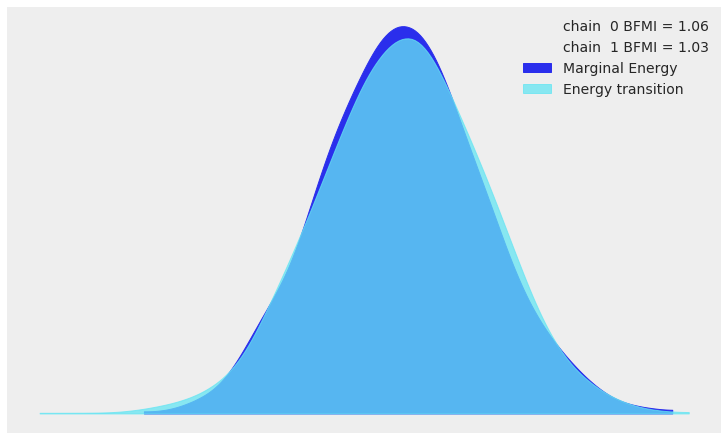

In [12]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [13]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=model_gm)

100%|██████████| 250/250 [00:01<00:00, 246.77it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


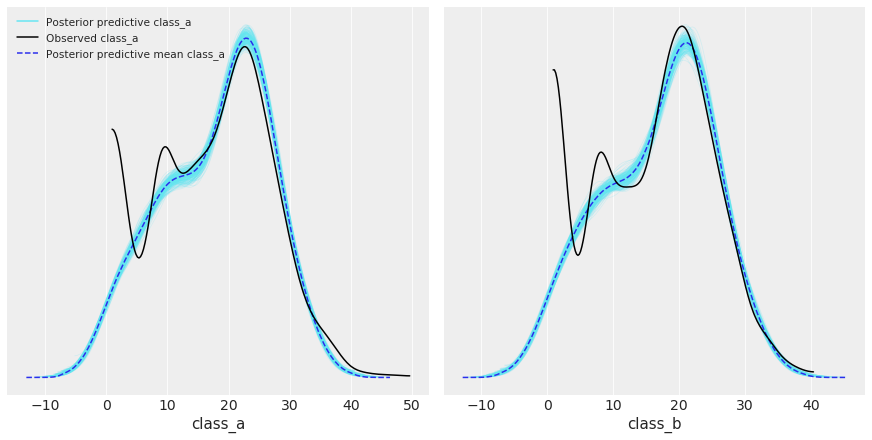

In [14]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [15]:
print(az.r2_score(x_sa, ppc['class_a']))

r2        0.860709
r2_std    0.010736
dtype: float64


In [16]:
print(az.r2_score(x_sb, ppc['class_b']))

r2        0.848577
r2_std    0.011458
dtype: float64


In [17]:
print(az.bfmi(trace_gm))

[1.06045045 1.02777974]


# Posterior samples vs. mean data

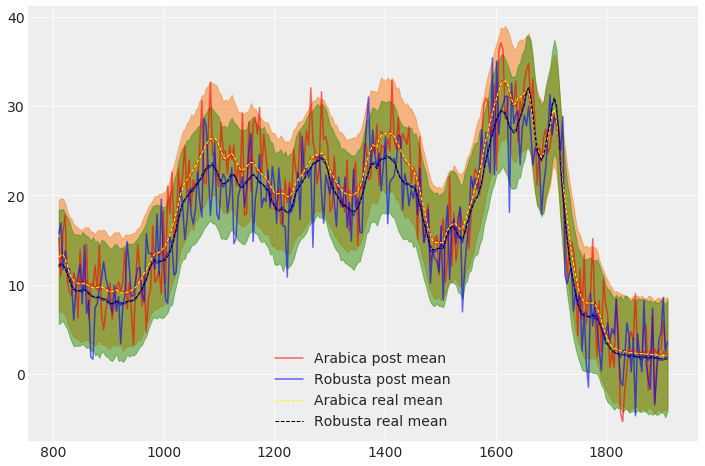

In [18]:
# draw class samples from the posterior
cl_a = ppc['class_a']
cl_b = ppc['class_b']

ppc_class_lst = [cl_a, cl_b]

# get header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

plt.figure(figsize=(12,8))
plt.axes()

# plot some samples from the posterior
for i in range(1):
    plt.plot(x_val, cl_a[i,0,:], '-', color="red", alpha=.6)
    plt.plot(x_val, cl_b[i,0,:], '-', color="blue", alpha=.6)

# plot the posterior mean
plt.plot(x_val, cl_a[:,0].mean(axis=0), '-', color="red", alpha=.6, 
         label='Arabica post mean')
plt.plot(x_val, cl_b[:,0].mean(axis=0), '-', color="blue", alpha=.6, 
         label='Robusta post mean')

# plot mean data for classes (raw data)
df1 = data.loc[data['label'] == clabels[0]]
df2 = data.loc[data['label'] == clabels[1]]

plt.plot(x_val, df1.iloc[:,:ndata_cols].mean(), '--', color='yellow', 
         label='Arabica real mean', linewidth=1)
plt.plot(x_val, df2.iloc[:,:ndata_cols].mean(), '--', color='black', 
         label='Robusta real mean', linewidth=1)
    
# plot 95% HPD interval
az.plot_hpd(x_val, ppc['class_a'], smooth=False, color='C1')
az.plot_hpd(x_val, ppc['class_b'], smooth=False, color='C2')

plt.legend(loc='best');

# Real spectrum vs. posterior samples

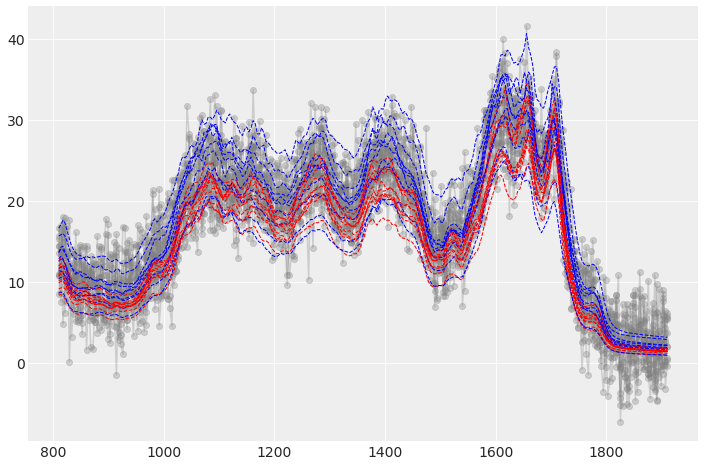

In [19]:
utl.plot_real_vs_ppc(data, ppc_class_lst, ndata_cols, clabels, label_col, 10)

# Save posterior samples to .csv file

In [20]:
samples_per_class = 100
filename = './ppc_samples_coffees.csv' 

utl.save_traces(filename, samples_per_class, x_val, clabels, ppc_class_lst)